In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


# 유틸

In [2]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [3]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

여러분의 설정한 구글 드라이브의 폴더 이름을 넣습니다.

In [4]:
import os
base_gdrive_path = os.path.join("drive", "MyDrive", "lecture_220711")

설정한 구글 드라이브 폴더의 하위에 `results` 라는 이름의 폴더를 생성한 후, 다음을 실행합니다.

In [5]:
result_path = os.path.join(base_gdrive_path, "results")

# Dataset

## 다운로드

In [6]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [7]:
# cv2가 처리하지 못하는 파일 삭제

!rm -f images/Egyptian_Mau_177.jpg
!rm -f annotations/trimaps/Egyptian_Mau_177.jpg

!rm -f images/Egyptian_Mau_191.jpg
!rm -f annotations/trimaps/Egyptian_Mau_191.jpg

!rm -f images/Egyptian_Mau_139.jpg
!rm -f annotations/trimaps/Egyptian_Mau_139.jpg

!rm -f images/Egyptian_Mau_145.jpg
!rm -f annotations/trimaps/Egyptian_Mau_145.jpg

!rm -f images/Egyptian_Mau_167.jpg
!rm -f annotations/trimaps/Egyptian_Mau_167.jpg

!rm -f images/Abyssinian_34.jpg
!rm -f annotations/trimaps/Abyssinian_34.jpg

## 확인

In [8]:
import cv2
import os

# 다양한 크기

mask = cv2.imread(os.path.join("annotations", "trimaps", "Abyssinian_2.png"))
print(mask.shape)

img = cv2.imread(os.path.join("images", "Abyssinian_2.jpg"))
print(img.shape)

resized_img = cv2.resize(img, (256, 256))
print(resized_img.shape)

# 이미지와 마스크가 서로 다른 파일 개수

print(len(os.listdir(os.path.join("annotations", "trimaps"))))
print(len(os.listdir(os.path.join("images"))))

# 이미지는 jpg, 마스크는 png.

len(list(filter(lambda el: el[-3:] == "png", os.listdir(os.path.join("annotations", "trimaps")))))

# 이미지는 color. 마스크는 grayscale.

(473, 600, 3)
(473, 600, 3)
(256, 256, 3)
14780
7384


14780

# U-Net

## 준비

In [9]:
batch_size = 32
seed = 42

In [10]:
# from keras.preprocessing.image import ImageDataGenerator

# img_generator = ImageDataGenerator()
# img_generator.flow_from_directory(
#     ".", 
#     classes=["images"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

# mask_generator = ImageDataGenerator()
# mask_generator.flow_from_directory(
#     "annotations", 
#     classes=["trimaps"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

## Generator 만들기

### Generator 생성

In [11]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [12]:
import toolz
import numpy as np

def img_mask_generator(img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

    yield np.array(img_batch), np.array(mask_batch)

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [13]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

### 샘플 이미지 플롯

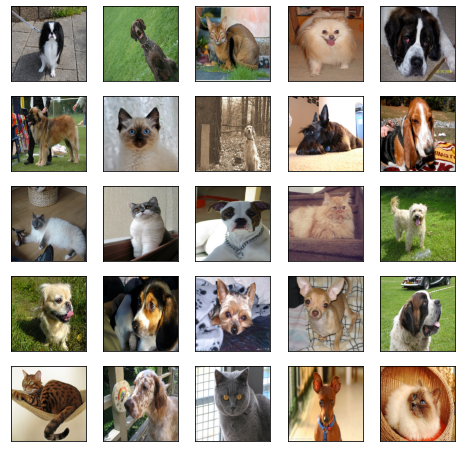

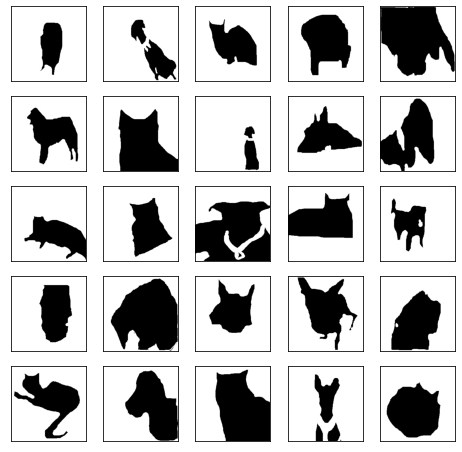

In [14]:
plt.figure(figsize=(8, 8))

img_mask_batch = next(train_batch_generator)

for i in range(25):
  _img = np.float32(img_mask_batch[0][i])
  _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_img, cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(8, 8))

for i in range(25):
  _mask = np.reshape(img_mask_batch[1][i], (256, 256))

  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_mask, cmap=plt.cm.binary)
plt.show()


### Generator 초기화

In [15]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

## 모델

### 모델 생성

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [16]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

참고 (원본 논문의 U-Net)

In [17]:
# 원본 U-Net 논문 구현이지만, 메모리가 너무 많이 든다.
def vanilla_unet(sz=(256, 256, 3)):
  base_num_filter = 64

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)

  # BottleNeck
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [18]:
# 깊이를 줄인 U-Net

def unet(sz=(256, 256, 3)):
  base_num_filter = 64

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)

  # BottleNeck
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  # Head (top)
  output = Conv2D(1, 1, activation='softmax')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [19]:
# 약간 변형된 U-Net 1
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  
  ff2 = 64 
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
#   model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [20]:
# 약간 변형된 U-Net 2
def unet(sz=(256, 256, 3)):
  base_num_filter = 8

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  skip5 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip5])
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [21]:
model = unet()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = [mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

### 모델 트레이닝

In [22]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

val_image_list = list(map(lambda v: with_ext(v, "jpg"), val_image_names))

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        # print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(val_image_list)
        img = cv2.imread(f'images/{path}')
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img / 255.

        target_mask = cv2.imread(os.path.join("annotations", "trimaps", "{}.png".format(path[:-4])))
        target_mask = cv2.resize(target_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        target_mask[target_mask >= 2] = 0
        target_mask[target_mask != 0] = 1
        
        # predict the mask 
        pred = model.predict(np.expand_dims(img, 0))
        
        # mask post-processing 
        msk = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        # show the mask and the segmented image 
        img = img.astype(np.float32) 
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, target_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.5998 - mean_iou: 0.0499

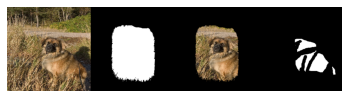

197/197 [==============================] - 65s 255ms/step - loss: 0.5998 - mean_iou: 0.0499 - val_loss: 0.4602 - val_mean_iou: 0.4664
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.4717 - mean_iou: 0.4209

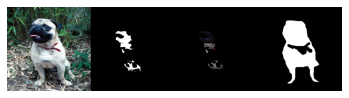

197/197 [==============================] - 48s 244ms/step - loss: 0.4717 - mean_iou: 0.4209 - val_loss: 0.4760 - val_mean_iou: 0.2490
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.4372 - mean_iou: 0.4506

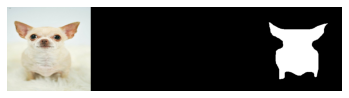

197/197 [==============================] - 48s 246ms/step - loss: 0.4372 - mean_iou: 0.4506 - val_loss: 0.4529 - val_mean_iou: 0.1779
Epoch 4/10
197/197 [==============================] - ETA: 0s - loss: 0.4205 - mean_iou: 0.4754

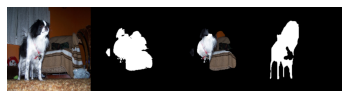

197/197 [==============================] - 48s 246ms/step - loss: 0.4205 - mean_iou: 0.4754 - val_loss: 0.4250 - val_mean_iou: 0.4314
Epoch 5/10
197/197 [==============================] - ETA: 0s - loss: 0.3950 - mean_iou: 0.5185

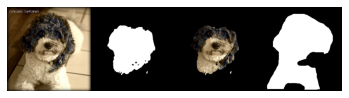

197/197 [==============================] - 48s 245ms/step - loss: 0.3950 - mean_iou: 0.5185 - val_loss: 0.3791 - val_mean_iou: 0.4972
Epoch 6/10
197/197 [==============================] - ETA: 0s - loss: 0.3582 - mean_iou: 0.5730

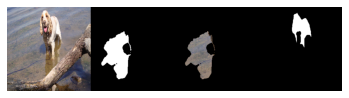

197/197 [==============================] - 49s 248ms/step - loss: 0.3582 - mean_iou: 0.5730 - val_loss: 0.4097 - val_mean_iou: 0.4031
Epoch 7/10
197/197 [==============================] - ETA: 0s - loss: 0.3279 - mean_iou: 0.6099

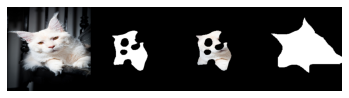

197/197 [==============================] - 48s 246ms/step - loss: 0.3279 - mean_iou: 0.6099 - val_loss: 0.3495 - val_mean_iou: 0.5632
Epoch 8/10
197/197 [==============================] - ETA: 0s - loss: 0.3036 - mean_iou: 0.6434

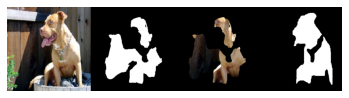

197/197 [==============================] - 49s 248ms/step - loss: 0.3036 - mean_iou: 0.6434 - val_loss: 0.4088 - val_mean_iou: 0.4103
Epoch 9/10
197/197 [==============================] - ETA: 0s - loss: 0.2794 - mean_iou: 0.6705

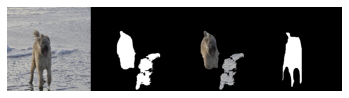

197/197 [==============================] - 49s 248ms/step - loss: 0.2794 - mean_iou: 0.6705 - val_loss: 0.3174 - val_mean_iou: 0.6026
Epoch 10/10
197/197 [==============================] - ETA: 0s - loss: 0.2597 - mean_iou: 0.6949

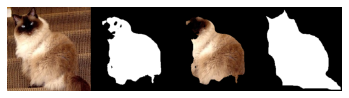

197/197 [==============================] - 49s 247ms/step - loss: 0.2597 - mean_iou: 0.6949 - val_loss: 0.3417 - val_mean_iou: 0.5629


In [23]:
train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model.fit(
    train_batch_generator,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), 
    verbose = 1)

[0.04994027689099312, 0.42091652750968933, 0.45058584213256836, 0.4754120409488678, 0.5185454487800598, 0.5730421543121338, 0.609885036945343, 0.6433688998222351, 0.6705338358879089, 0.69493567943573]
[0.46641260385513306, 0.24904043972492218, 0.17794053256511688, 0.4314183294773102, 0.49717167019844055, 0.4030703604221344, 0.5631556510925293, 0.4103417694568634, 0.6025925874710083, 0.5628516674041748]


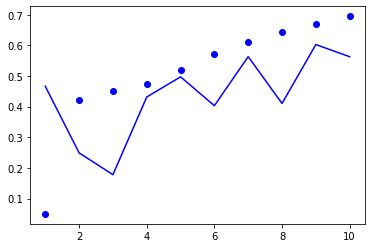

In [24]:
history_accuracy = history.history["mean_iou"]
history_val_accuracy = history.history["val_mean_iou"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[0.5998368859291077, 0.47168296575546265, 0.4372299909591675, 0.4204881191253662, 0.3949909508228302, 0.35823339223861694, 0.3278651237487793, 0.3035767376422882, 0.2793765366077423, 0.2597072124481201]
[0.4602009356021881, 0.4760368764400482, 0.45286795496940613, 0.4249548316001892, 0.3790707588195801, 0.4096718728542328, 0.3494716286659241, 0.4087870419025421, 0.3173869848251343, 0.3417423367500305]


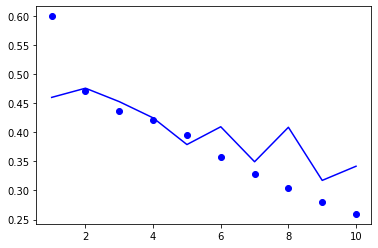

In [25]:
history_loss = history.history["loss"]
history_val_loss = history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

### 모델 테스트 및 예측

In [26]:
test_steps = len(test_image_names) // batch_size
test_loss, test_acc = model.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_acc)

11/11 - 2s - loss: 0.3802 - mean_iou: 0.5377 - 2s/epoch - 192ms/step
테스트 정확도: 0.5376825332641602


In [27]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2022-07-12 07:14:55--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 18.65.39.49, 18.65.39.123, 18.65.39.2, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|18.65.39.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.006s  

2022-07-12 07:14:56 (9.70 MB/s) - ‘test.jpg’ saved [63219/63219]



In [28]:
import cv2
img = cv2.imread('test.jpg')
img.shape

(720, 720, 3)

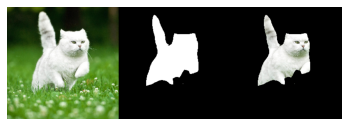

In [29]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

### 모델 저장

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
save_model(os.path.join(result_path, "unet_000.json"), model)

run_id: str = "001"
weight_file_name = "unet_000__{}.hdf5".format(run_id)

model.save_weights(os.path.join(result_path, weight_file_name))

In [33]:
json_model_path = os.path.join(result_path, "unet_000.json")
model_weight_path = os.path.join(result_path, weight_file_name)
loaded_model2_with_weight = load_model(json_model_path, model_weight_path)

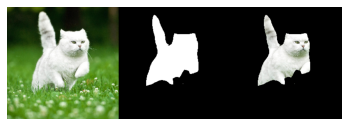

In [34]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = loaded_model2_with_weight.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# U-Net 함수형 모델

In [35]:
def unet_downsampling(input_layer, channel_num, do_max_pool=True):
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(input_layer)
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)
    x_skip = x
    if do_max_pool:
        x = MaxPooling2D()(x)

    return x_skip, x

def unet_bottleneck(input_layer, channel_num):
    x = MaxPooling2D()(input_layer)
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)

    return x

def unet_upsampling(input_layer, concat_layer, channel_num):
    x = UpSampling2D()(input_layer)
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)
    x = Concatenate()([concat_layer, x])
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)
    x = Conv2D(channel_num, 3, activation='relu', padding='same')(x)

    return x


In [36]:
def unet_func(image_size = (256, 256, 3)):
    base_channel = 16

    input = Input(image_size)

    # 다운 샘플링
    x_skip_1, x = unet_downsampling(input, base_channel)
    x_skip_2, x = unet_downsampling(x, base_channel*2)
    x_skip_3, x = unet_downsampling(x, base_channel*4)
    x_skip_4, x = unet_downsampling(x, base_channel*8, do_max_pool=False)

    # 병목
    x = unet_bottleneck(x, base_channel*16)

    # 업 샘플링
    x = unet_upsampling(x, x_skip_4, base_channel*8)
    x = unet_upsampling(x, x_skip_3, base_channel*4)
    x = unet_upsampling(x, x_skip_2, base_channel*2)
    x = unet_upsampling(x, x_skip_1, base_channel*1)

    # 픽셀 분류
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    return Model(inputs=[input], outputs=[x])


In [37]:
model_func_1 = unet_func()
model_func_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_28[0][0]']              
                                )                                                           

# U-Net 커스텀 레이어 모델

In [38]:
class UNetDownSamplingLayer(tf.keras.layers.Layer):
    def __init__(self, channel_num, do_max_pool=True):
        super(UNetDownSamplingLayer, self).__init__()
        self.channel_num = channel_num
        self.do_max_pool = do_max_pool
        
    def build(self, input_shape):
        self.conv_1 = Conv2D(self.channel_num, 3, activation='relu', padding='same')
        self.conv_2 = Conv2D(self.channel_num, 3, activation='relu', padding='same')
        
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x_skip = x
        if self.do_max_pool:
            x = MaxPooling2D()(x)

        return x_skip, x


class UNetUpSamplingLayer(tf.keras.layers.Layer):
    def __init__(self, channel_num):
        super(UNetUpSamplingLayer, self).__init__()
        self.channel_num = channel_num

    def build(self, input_shape):
        self.conv_1 = Conv2D(self.channel_num, 3, activation='relu', padding='same')
        self.conv_2 = Conv2D(self.channel_num, 3, activation='relu', padding='same')
        self.conv_3 = Conv2D(self.channel_num, 3, activation='relu', padding='same')
        
    def call(self, inputs):
        x = UpSampling2D()(inputs[0])
        x = self.conv_1(x)
        x = Concatenate()([inputs[1], x])
        x = self.conv_2(x)
        x = self.conv_3(x)

        return x


In [39]:
def unet_custom_layer(image_size = (256, 256, 3)):
    base_channel = 16

    input = Input(image_size)

    # 다운 샘플링
    x_skip_1, x = UNetDownSamplingLayer(base_channel)(input)
    x_skip_2, x = UNetDownSamplingLayer(base_channel*2)(x)
    x_skip_3, x = UNetDownSamplingLayer(base_channel*4)(x)
    x_skip_4, x = UNetDownSamplingLayer(base_channel*8, False)(x)

    # 병목
    x = unet_bottleneck(x, base_channel*16)

    # 업 샘플링
    x = UNetUpSamplingLayer(base_channel*8)([x, x_skip_4])
    x = UNetUpSamplingLayer(base_channel*4)([x, x_skip_3])
    x = UNetUpSamplingLayer(base_channel*2)([x, x_skip_2])
    x = UNetUpSamplingLayer(base_channel*1)([x, x_skip_1])

    # 픽셀 분류
    x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

    return Model(inputs=[input], outputs=[x])

In [40]:
model_cl_1 = unet_custom_layer()
model_cl_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 u_net_down_sampling_layer (UNe  ((None, 256, 256, 1  2768       ['input_3[0][0]']                
 tDownSamplingLayer)            6),                                                               
                                 (None, 128, 128, 1                                               
                                6))                                                               
                                                                                            